In [8]:
# Hyperparameters
learning_rate = 0.1          # Learning rate for updating Q-values
discount_rate = 0.99         # Discount rate for future rewards
initial_epsilon = 1.0        # Initial value of epsilon for epsilon-greedy policy
epsilon_decay = 0.995        # Decay rate of epsilon per episode
minimum_epsilon = 0.01       # Minimum value of epsilon to maintain some exploration

# Training parameters
total_episodes = 1000        # Total number of episodes to train
maximum_steps_per_episode = 300  # Maximum steps per episode to avoid infinite loops
print_table_interval = 100   # Interval after which to print the table

List of Scores:
[-1263, -1155, -1263, -1119, -1236, -1245, -1137, -1191, -1146, -677, -1155, -1137, -1155, -1074, -1155, -916, -1101, -1254, -1155, -1128, -1218, -1065, -1182, -489, -1056, -360, -459, -1101, -939, -593, -1110, -903, -1092, -466, -235, -1056, -984, -939, -118, -1182, -1047, -739, -809, -1002, -325, -497, -423, -885, -133, -225, -279, -266, -966, -290, -210, -984, -506, -114, -112, -496, -276, -729, -281, -813, -201, -849, -257, -556, -188, -78, -363, -136, -214, -105, -179, -132, -216, -159, -589, -196, -815, -50, -70, -245, -81, -273, -141, -245, -164, -206, -132, -822, -83, -437, -140, -140, -570, -146, -71, -250, -192, -165, -316, -291, -74, -109, -454, -178, -136, -113, -101, -31, -146, -112, -125, -39, -44, -98, -85, -13, -10, -40, -53, -155, -106, -20, -317, -45, -113, -10, -28, -132, -62, -20, -12, -109, -822, -29, -30, -86, -47, -57, -31, -140, -204, -22, -33, -46, -48, -59, -91, -50, -27, -22, -53, -57, -78, -19, -50, -714, -104, -57, -50, -34, -19, -18, -31, -

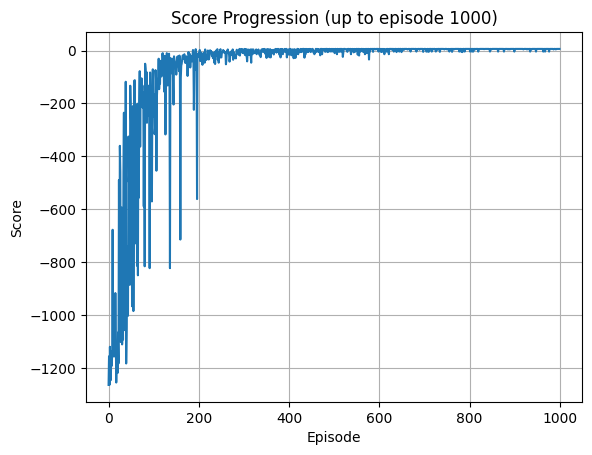

In [9]:
import subprocess
import sys
import os

# Function to install necessary Python packages
def install_package(package_name):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])

# List of required packages
required_packages = ['gymnasium', 'numpy', 'matplotlib', 'pandas', 'fpdf']

# Ensure necessary packages are installed
for package in required_packages:
    try:
        __import__(package)
    except ImportError:
        install_package(package)

import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, clear_output
from matplotlib.backends.backend_pdf import PdfPages
import functools

# Create the results directory if it doesn't exist
if not os.path.exists('results'):
    os.makedirs('results')

# Create Taxi environment
taxi_environment = gym.make('Taxi-v3')
taxi_environment.reset(seed=123)

# Function to convert state tuple to integer
def convert_tuple_to_int(state_tuple) -> int:
    if isinstance(state_tuple, tuple):
        if isinstance(state_tuple[-1], dict):
            return functools.reduce(lambda sub, ele: sub * 10 + ele, state_tuple[:-1])
        else:
            return functools.reduce(lambda sub, ele: sub * 10 + ele, state_tuple)
    else:
        return state_tuple

# Initialize q-table with small random values
number_of_states = taxi_environment.observation_space.n
number_of_actions = taxi_environment.action_space.n
q_table = np.random.uniform(low=-1, high=1, size=(number_of_states, number_of_actions))

# List to track the scores during training
episode_scores = []

# Prepare PDF file for output
pdf_file = PdfPages('results/reinforcement_learning_plots.pdf')

# Training process
epsilon = initial_epsilon
plt.ion()
figure, axis = plt.subplots()
for episode in range(total_episodes):
    state = taxi_environment.reset(seed=123)
    total_reward = 0
    episode_done = False
    for _ in range(maximum_steps_per_episode):
        # Exploration-exploitation tradeoff
        encoded_state = convert_tuple_to_int(state)
        if random.uniform(0, 1) < epsilon:
            action = taxi_environment.action_space.sample()  # Explore
        else:
            action = np.argmax(q_table[encoded_state, :])  # Exploit

        new_state, reward, episode_done, _, _ = taxi_environment.step(action)
        new_state = convert_tuple_to_int(new_state)  # Convert new_state tuple to integer
        total_reward += reward

        # Q-learning algorithm
        target_q_value = reward + discount_rate * np.max(q_table[convert_tuple_to_int(new_state), :])
        current_q_value = q_table[encoded_state, action]
        updated_q_value = current_q_value + learning_rate * (target_q_value - current_q_value)
        q_table[encoded_state, action] = updated_q_value

        state = new_state

        if episode_done:
            break
    
    # Decay epsilon
    epsilon = max(minimum_epsilon, epsilon * epsilon_decay)

    # Add the total reward of the episode to the scores list
    episode_scores.append(total_reward)

    if (episode + 1) % print_table_interval == 0:
        # Display the scores as a table
        scores_dataframe = pd.DataFrame(episode_scores, columns=["Score"])
        display(scores_dataframe.tail(10))  # Display the last 10 scores for inspection

        # Plot scores up to the current episode
        axis.clear()
        axis.plot(episode_scores)
        axis.set_xlabel('Episode')
        axis.set_ylabel('Score')
        axis.set_title(f'Score Progression (up to episode {episode + 1})')
        axis.grid(True)
        
        # Save plot to PDF
        pdf_file.savefig(figure)
        
        clear_output(wait=True)

plt.ioff()
pdf_file.close()

# Print the list of scores
print("List of Scores:")
print(episode_scores)

# Close the environment
taxi_environment.close()